# Covered Distance

Exertion metrics like covered distance, and covered distance in different speed and acceleration zones are one of the most used metrics from soccer tracking data. The information is uses for load monitoring and it is even tried to link it to the outcome of the game. Optical tracking data has advantages over gps based tracking data since the concrete walls of big stadiums tend to influence the accuracy of GPS systems. Furthermore, it is often not financially feasable to have LPM systems installed in all the stadiums where your team plays. Optical tracking data gives the solution to load monitoring in matches. Lets start by loading in a `Match` object and get coding on the covered distance feature!


```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()
```

```{note}
The current supported tracking data providers are:

- Tracab
- Metrica
- Inmotio

The current supported event data provider are:
- Opta
- Metrica
- Instat

If you wish to use a different provider that is not listed here, please open an issue [here](https://github.com/Alek050/databallpy/issues)
```

Since player velocity is often calculated in tracking data, we will use the velocity to compute the covered distance. After all, if you are running at 10 $m/s$ for 1 second, your distance covered is 10 $m$. 

```{tip}
Use the `add_velocity` function from the `databallpy.features` module to compute the velocity of your players.
```

In [2]:
from databallpy import get_saved_match
from databallpy.features import add_velocity
import os

match = get_saved_match("synced_match", os.path.join(os.getcwd(), "../saved_matches"))
match.tracking_data = add_velocity(match.tracking_data, match.home_players_column_ids() + match.away_players_column_ids(), match.frame_rate, "savitzky_golay", max_velocity=13.)

In [18]:
import pandas as pd

def get_covered_distance(
    tracking_data: pd.DataFrame,
    column_ids: list[str],
    frame_rate: int,
) -> pd.DataFrame:
    
    column_ids = sorted(column_ids)
    result_dict = ({"total_distance": []})

    tracking_data_velocity = pd.concat(
        [tracking_data[player_id + "_velocity"] for player_id in column_ids], axis=1
    ).fillna(0)
    tracking_data_velocity.columns = tracking_data_velocity.columns.str.replace(
        "_velocity", ""
    )
    distance_per_frame = tracking_data_velocity / frame_rate
    result_dict["total_distance"] = distance_per_frame.sum().values
    return pd.DataFrame(result_dict, index=column_ids)

covered_distances_home_players = get_covered_distance(
    match.tracking_data.iloc[:60*match.frame_rate],
    column_ids = match.home_players_column_ids(),
    frame_rate=match.frame_rate
)

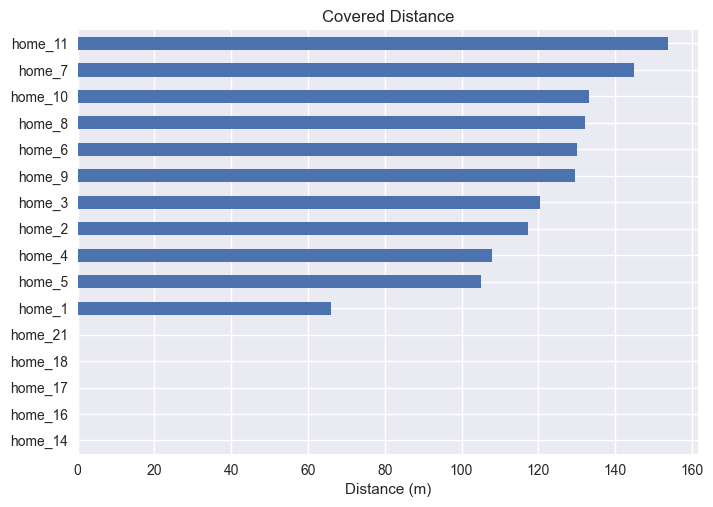

In [44]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
covered_distances_home_players.sort_values(by="total_distance", inplace=True)
covered_distances_home_players["total_distance"].plot(xlabel="Distance (m)", kind="barh")
plt.title("Covered Distance")
plt.show()

11 of the 16 players covered some distance. The keeper had the lowest covered distance (home_1) and home_11 covered the most distance. all other players covered at least 105 meters in the first 60 seconds of the match. Although helpfull, to quantify exertion and biomechanical load, it could be more intersting to look at the distance covered in different velocity and acceleration zones.

## Distance Covered in Velocity and Acceleration Zones

To parse the zones we can provide the velocity zones in $m/s$ like this `velocity_zones = ((0, 3), (3, 6), (6, np.inf))`. Lets update the function so it can handle these values.


In [31]:
import numpy as np

def _add_covered_distance_interval(
    result_dict: dict,
    interval_type: str,
    tracking_data: pd.DataFrame,
    distance_per_frame: pd.DataFrame,
    intervals: list[tuple[float, float]],
    column_ids: list[str],
) -> dict:
    for player_id in column_ids:
        for min_val, max_val in intervals:
            mask = tracking_data[player_id + "_" + interval_type].between(
                min_val, max_val
            )
            total_distance = distance_per_frame[player_id][mask].sum()
            result_dict[f"total_distance_{interval_type}_{min_val}_{max_val}"].append(
                total_distance
            )
    return result_dict

def get_covered_distance(
    tracking_data: pd.DataFrame,
    column_ids: list[str],
    frame_rate: int,
    velocity_intervals: tuple[tuple[float, float]] = (),
    acceleration_intervals: tuple[tuple[float, float]] = ()
) -> pd.DataFrame:
    
    column_ids = sorted(column_ids)

    # Different initialization of result dict
    result_dict = (
            {"total_distance": []}
            | {
                f"total_distance_velocity_{interval[0]}_{interval[1]}": []
                for interval in velocity_intervals
            }
            | {
                f"total_distance_acceleration_{interval[0]}_{interval[1]}": []
                for interval in acceleration_intervals
            }
        )

    tracking_data_velocity = pd.concat(
        [tracking_data[player_id + "_velocity"] for player_id in column_ids], axis=1
    ).fillna(0)
    tracking_data_velocity.columns = tracking_data_velocity.columns.str.replace(
        "_velocity", ""
    )
    distance_per_frame = tracking_data_velocity / frame_rate
    result_dict["total_distance"] = distance_per_frame.sum().values

    # Add covered distance in velocity or acceleration intervals
    for interval, interval_name in zip ([velocity_intervals, acceleration_intervals], ["velocity", "acceleration"]):
        if len(interval) > 0:
            result_dict = _add_covered_distance_interval(
                result_dict,
                interval_name,
                tracking_data,
                distance_per_frame,
                velocity_intervals,
                column_ids,
            )

    return pd.DataFrame(result_dict, index=column_ids)

covered_distances_home_players = get_covered_distance(
    match.tracking_data.iloc[:60*match.frame_rate],
    column_ids = match.home_players_column_ids(),
    frame_rate=match.frame_rate,
    velocity_intervals=((0, 3), (3, 6), (6, np.inf))
)

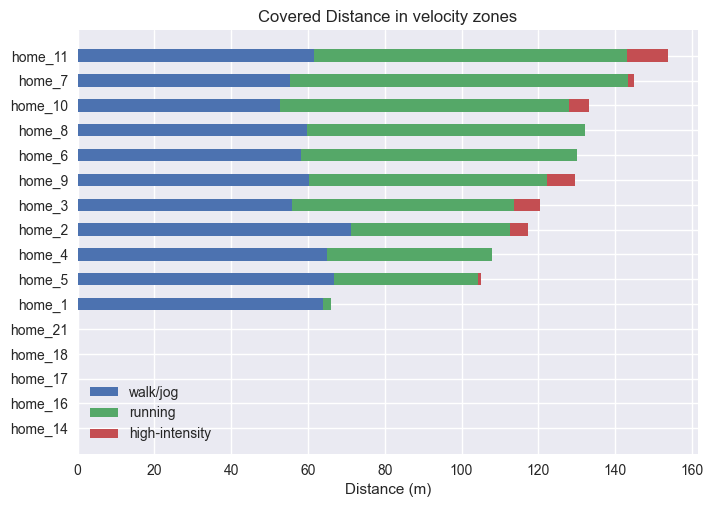

In [43]:
covered_distances_home_players.sort_values(by="total_distance", inplace=True)

stacked_plot_data = {
    "walk/jog": covered_distances_home_players["total_distance_velocity_0_3"].values,
    "running": covered_distances_home_players["total_distance_velocity_3_6"].values,
    "high-intensity": covered_distances_home_players["total_distance_velocity_6_inf"].values,
}


fig, ax = plt.subplots()
left = np.zeros(len(covered_distances_home_players))
for intesity_zone, distances in stacked_plot_data.items():
    ax.barh(covered_distances_home_players.index, distances, height=0.5, left=left, label=intesity_zone)
    left += distances
ax.set_xlabel("Distance (m)")    
ax.legend()
ax.set_title("Covered Distance in velocity zones")
plt.show()


## Covered Distance in DataBallPy

The DataBallPy package supports the `get_covered_distance` function from the `databallpy.features` module:

```python
from databallpy.features import get_covered_distance
```

### Parameters

- **tracking_data (pd.DataFrame)**: The tracking data of the match.
- **column_ids (list[str])**: A list with the column ids of the players over which you would like to calculate the covered distance. If you want to get the covered distance of all players, you can parse `match.home_players_column_ids() + match.away_players_column_ids()`. For instance, if you wish to calculate the covered distance of the home players with jersy number 3 and 14, it should be `["home_3", "home_14"]`.
- **frame_rate (int)**: The frame rate of the match which can be obtained from `match.frame_rate`.
- **velocity_intervals (tuple[tuple[float]] | tuple[float], optional)**: The velocity intervals over which to calculate the covered distance in $m/s$. This can be parsed in two ways. First, tuples with specific intervals: `((0, 3), (3, 6), (6, np.inf))`. Second, tuple with floats: `(0, 3, 6, np.inf)`. Both these inputs will result in the same outcome. Defaults to `()`.
- **acceleration_intervals (tuple[tuple[float]] | tuple[float], optional)**: The acceleration intervals over which to calculate the covered distance in $m/s^2$. This can be parsed in two ways. First, tuples with specific intervals: `((0, 3), (3, 6), (6, np.inf))`. Second, tuple with floats: `(0, 3, 6, np.inf)`. Both these inputs will result in the same outcome. Defaults to `()`.

```{warning}
Be aware when using acceleration data from optical or gps tracking data. These data need to be differentiated twice. Apply sufficient filters in the `add_acceleration` functions to prevent big errors in the acceleration computations
```

- **start_idx (int, optional)**: The index of the tracking data from where to start the covered distance calculation. This can be usefull when you want to compute the covered distance in specific periods of the match. Note that the `start_idx` needs to correspond to an index in the tracking data. Defaults to None.
- **end_idx (int, optional)**: The index of the tracking data from where to end the covered distance calculation. This can be usefull when you want to compute the covered distance in specific periods of the match. Note that the `end_idx` needs to correspond to an index in the tracking data. Defaults to None.


**Returns**
pd.DataFrame with the total covered distance within the `start_idx` and `end_idx`, and for every velocity and acceleration intensity zone.
